<a href="https://colab.research.google.com/github/liman8/Notebooks/blob/main/Z3_2024_studentska.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paralelno računarstvo - CUDA Z3


## Preduslovi
Kao prvi korak, **obavezno** napravite kopiju ove sveske na svom Google Drive-u (klikom na opciju *Copy to Drive* u meniju na vrhu), kako biste mogli da sačuvate izmene i pokrenete izvršavanje.

Zatim, pre nego započnete implementaciju zadataka, **obavezno** izvršite kod iz ćelije ispod. Kod će:
- skinuti kompresovanu biblioteku `libwb` koja se koristi u zadacima i raspakovati je na putanju /usr/local/libwb.

**Obavezno** promeniti link tako da se biblioteka učitava sa Vašeg ličnog Google drive-a.

In [ ]:
%%bash

######################### PREUZMI I PODESI libwb ##############################
# preuzmi libwb.zip ako već nije preuzet
[[ -f libwb.zip ]] || wget -O libwb.zip "https://drive.google.com/u/0/uc?id=1yzUz-Rnmquj_3wAoPFLCUDhLTsEMMmGi&export=download"

# otpakuj
unzip -oqqd /usr/local libwb.zip

Po završetku prethodne ćelije, možete pokrenuti narednu koja proverava da li `libwb` direktorijum postoji na predviđenoj putanji. Ukoliko je sve u redu, naredba će ispisati absolutnu putanju do direktorijuma. U suprotnom će prijaviti da direktorijum nije pronađen. U tom slučaju treba se vratiti na log prethodne ćelije i potražiti gde je došlo do greške.

In [ ]:
%%bash

ls -d /usr/local/libwb/

Pokrenite naredbu iz sledeće ćelije kako biste proverili da li je dostupan CUDA kompajler. Ukoliko je kompajler dostupan, ova naredba će ispisati informacije o njemu, uključujući i verziju CUDA-e. Ukoliko postoji problem, biće prijavljeno da komanda *nvcc* nije dostupna. U tom slučaju treba proveriti da li je kao trenutno okruženje (runtime) izabrano GPU.

In [ ]:
!nvcc --version

## [Opciono] Deinstalacija `libwb` biblioteke
Izvršavanjem ćelije ispod briše se instalirana biblioteka `libwb`. Izvršite ovu ćeliju samo ako želite da reinstalirate `libwb` biblioteku.

In [ ]:
%%bash

# obrisi libwb biblioteku
[[ -d /usr/local/libwb ]] && rm -r /usr/local/libwb/ && echo "Obrisana libwb biblioteka."
[[ -f libwb.zip ]] && rm libwb.zip && echo "Obrisana libwb.zip arhiva."

## Zadatak &ndash; Rotiranje matrice za 90 stepeni u smeru kazaljke na satu

Korišćenjem CUDA tehnologije napisati program koji ulaznu matricu veličine NxM transformiše u matricu veličine MxN rotirajući ulaznu matricu za 90 stepeni u smeru kazaljke na satu. Primer je ilustrovan na slici ispod.

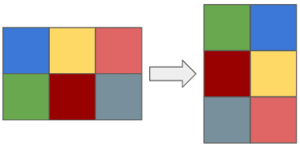

Nekoliko primera sa konkretnim vrednostima matrice:
1. Primer sa kvadratnom matricom veličine 6x6:

Matrica

\begin{bmatrix}
1 & 2 & 3 & 4 & 5 & 6 \\
7 & 8 & 9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16 & 17 & 18 \\
19 & 20 & 21 & 22 & 23 & 24 \\
25 & 26 & 27 & 28 & 29 & 30 \\
31 & 32 & 33 & 34 & 35 & 36
\end{bmatrix}

  
postaje

\begin{bmatrix}
31 & 25 & 19 & 13 & 7 & 1 \\
32 & 26 & 20 & 14 & 8 & 2 \\
33 & 27 & 21 & 15 & 9 & 3 \\
34 & 28 & 22 & 16 & 10 & 4 \\
35 & 29 & 23 & 17 & 11 & 5 \\
36 & 30 & 24 & 18 & 12 & 6
\end{bmatrix}

2. Primer sa nekvadratnom matricom veličine 4x8:

Matrica

\begin{bmatrix}
1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 & 13 & 14 & 15 & 16 \\
17 & 18 & 19 & 20 & 21 & 22 & 23 & 24 \\
25 & 26 & 27 & 28 & 29 & 30 & 31 & 32
\end{bmatrix}

postaje

\begin{bmatrix}
25 & 17 & 9 & 1 \\
26 & 18 & 10 & 2 \\
27 & 19 & 11 & 3 \\
28 & 20 & 12 & 4 \\
29 & 21 & 13 & 5 \\
30 & 22 & 14 & 6 \\
31 & 23 & 15 & 7 \\
32 & 24 & 16 & 8
\end{bmatrix}

Koraci koje treba implementirati na naznačenim mestima u kodu su sledeći:

*   alocirati memoriju na domaćinu (samo za hostOutput),
*   alocirati svu potrebnu memoriju na uređaju,
*   kopirati memoriju sa domaćina na uređaj (obratite pažnju da **kopirate na uređaj samo ono što je neophodno**),
*   izračunati dimenzije mreže; dimenzija bloka određena je makroom `BLOCKSIZE` (videti u pasusu ispod kako se `BLOCKSIZE` može podesiti); **NAPOMENA:** maksimalna dozovljena vrednost ovog makroa je 32, jer CUDA neće dozvoliti više od `32*32=1024` niti po bloku,
*   pozvati kernel na izvršenje,
*   kopirati memoriju, odnosno rezultat, sa uređaja na domaćina,
*   osloboditi memoriju zauzetu na uređaju,
*   osloboditi memoriju zauzetu na domaćinu (uključujući i hostInput), i
*   implementirati kernel koji izvršava glavnu logiku programa.

Treba pokrenuti **onoliko niti koliko ima elemenata u matrici**. Pretpostaviti da **neće uvek u pitanju biti kvadratna matrica**, ali da će blok **uvek biti kvadratnog oblika** i da je veličina bloka takva da su **obe dimenzije matrice uvek deljive sa veličinom bloka**. Dimenzija bloka može se postaviti definisanjem makroa `BLOCKSIZE` pri kompajliranju. Da biste to učinili, u ćeliji za kompajliranje izmenite opciju `-DBLOCKSIZE=4` tako da umesto 4 stoji veličina bloka koju želite.

### Tesitranje
Postoji 13 unapred pripremljenih testova. Veličine ulaznih matrica u testovima su sledeće:

| Redni broj testa | Veličina ulazne matrice |
| ---------------- | ----------------------- |
| 0                | 4x8                     |
| 1                | 8x8                     |
| 2                | 16x16                   |
| 3                | 32x32                   |
| 4                | 64x64                   |
| 5                | 16x128                  |
| 6                | 64x128                  |
| 7                | 256x32                  |
| 8                | 6x6                     |
| 9                | 27x45                   |
| 10               | 207x90                  |
| 11               | 10x5                    |
| 12               | 175x35                  |

Očekuje se da napišete rešenje tako da, ako su **obe** dimenzije matrice iz nekog testa veće ili jednake `BLOCKSIZE`, i deljive sa `BLOCKSIZE`, taj test bude uspešan. Na primer, ako se postavi `-DBLOCKSIZE=2`, očekuje se da testovi 0-8 budu uspešni; ako se postavi `-DBLOCKSIZE=16`, očekuje se da prođu testovi 2-7. Takođe, `BLOCKSIZE`, kao i dimenzije matrice, ne moraju biti stepen dvojke, što je slučaj u poslednjih 5 testova.

Pokretanje testa koji prođe uspešno ispisaće "Solution is correct". Ne očekujte da u jednom pokretanju prođu svi testovi; prolaznost zavisi od odnosa dimenzija matrice i vrednosti `BLOCKSIZE`, kao što je objašnjeno u prethodnom pasusu. Ispod sekcije za kôd nalaze se sekcije koje možete pokrenuti za testiranje pojedinačnih primera, kao i za testiranje svih primera zajedno. Da biste izabrali koji će se primer zasebno testirati, u ćeliji za pojedinačno testiranje na mesto nule upišite bilo koji broj od 0 do 12. Na putanji `/home/cuda/rotate/dataset` nalaze se folderi čija su imena brojevi od 0 do 12. U svakom od njih postoji `input.raw` fajl koji se može prikazati duplim klikom. Na vrhu svakog *input* fajla su dva broja koji označavaju veličinu matrice, a nakon toga slede sami elementi matrice. Očekivano rešenje za svaki od primera možete videti otvaranjem `output.raw` fajlova (na istoj putanji gde i *input* fajlovi). Ako pokrenete samo jedan test, svoje rešenje možete videti u fajlu koji se takođe zove `output.raw`, a nalazi se na putanji `/home/cuda/rotate`. Za test primere sa malim matricama, možete otvarati pomenute fajlove i pregledati kako se Vaše rešenje razlikuje od očekivanog, za slučaj da test ne prolazi.

### Bodovanje

Za maksimalan broj poena, potrebno je:
* ispravno napisati sekcije u `main` funkciji koda domaćina,
* napisati kernel koji daje ispravno rešenje, i
* optimizovati kernel deljenom memorijom tako da pristup glavnoj memoriji, i pri čitanju i pri upisu, bude poravnat na nivou bloka niti. Veličine blokova će potencijalno biti manje od veličine *CUDA warp*-a, ali to je dozvoljeno i ne očekuje se da se bavite ovim problemom.

**NAPOMENE**:
* Bez kernela, odnosno implementiranjem samo odgovarajućeg dela u `main` funkciji, moguće je ostvariti maksimalno 8 poena.
* Zadatak urađen u potpunosti pruža mogućnost, ali ne garantuje maksimalan broj poena. Konačan broj poena biće određen tek nakon odbrane rešenja.

### Preuzimanje fajlova potrebnih za zadatak

**Obavezno** promeniti link tako da se učitava sa Vašeg ličnog Google drive-a.

In [ ]:
%%bash

# preuzmi dataset ako vec nije preuzet
[[ -f dataset_rotate.zip ]] || wget -O dataset_rotate.zip "https://drive.google.com/u/0/uc?id=1wcLrZZhb-UAkT2cq7b7z3p8nZDX6mH67&export=download"

# otpakuj u direktorijum u kojem ce se nalaziti izvrsna datoteka resenja
mkdir -p /home/cuda/rotate
unzip -oqqd /home/cuda/rotate dataset_rotate.zip

In [ ]:
%%bash

ls -d /home/cuda/rotate

### [Opciono] Brisanje zapakovanih i otpakovanih test primera
Izvršite ovu ćeliju ako želite da obrišete test podatke zarad ponovnog preuzimanja.

In [ ]:
%%bash

# obrisi set podataka za testiranje
[[ -d /home/cuda/rotate/dataset ]] && rm -r /home/cuda/rotate/dataset && echo "Obrisan set podataka za testiranje."
[[ -f dataset_rotate.zip ]] && rm dataset_rotate.zip && echo "Obrisana dataset_rotate.zip arhiva."

### Mesto za kod

Pokrenite ćelju sa kodom pre pokretanja testova, kako bi se fajl sa kodom sačuvao u fajl sistemu sveske. Ovo treba uraditi svaki put kada izmenite rešenje.

In [ ]:
%%writefile /home/cuda/rotate/rotate_matrix.cu

#include <wb.h>

#ifndef BLOCKSIZE
  #define BLOCKSIZE 4
#endif


#define wbCheck(stmt)                                                     \
  do {                                                                    \
    cudaError_t err = stmt;                                               \
    if (err != cudaSuccess) {                                             \
      wbLog(ERROR, "Failed to run stmt ", #stmt);                         \
      printf("Error: %d\n", err);                                         \
      printf("Error string: %s\n", cudaGetErrorString(err));              \
      return -1;                                                          \
    }                                                                     \
  } while (0)


/**
 * Kernel za transformaciju matrice.
 * Možete mu dodati proizvoljan broj argumenata.
 * Od postojećih, prvi argument je ulazna matrica.
 * U drugi treba smestiti rezultujuću matricu.
 */
__global__ void transformMatrix(float *inputMat, float *outputMat /*,...*/ ) {

  // TODO: implementirati logiku kernela

}

int main(int argc, char *argv[]) {

  wbArg_t args;

  /*
   * numRows -> Broj vrsta ulazne matrice. NE TREBA sami da postavljate.
   * Ova promenljiva biće automatski postavljena za vas.
   */
  int numRows;

  /*
   * numCols -> Broj kolona ulazne matrice. NE TREBA sami da postavljate.
   * Ova promenljiva biće automatski postavljena za vas.
   */
  int numCols;

  /*
   * Promenljive za ulazne i izlazne podatke na domaćinu.
   */
  float *hostInput;
  float *hostOutput;

  /*
   * Promenljive za ulazne i izlazne podatke na uređaju.
   */
  float *deviceInput;
  float *deviceOutput;

  args = wbArg_read(argc, argv);

  //@@ Ne alocirati ručno hostInput, to će učiniti wb biblioteka
  hostInput = (float *)wbImport(wbArg_getInputFile(args, 0), &numRows, &numCols);

  wbTime_start(Generic, "Alociranje memorije na domaćinu.");
  //@@ Ovde alocirati memoriju na domaćinu za hostOutput
  wbTime_stop(Generic, "Alociranje memorije na domaćinu.");

  wbTime_start(GPU, "Alociranje memorije na uređaju.");
  //@@ Ovde alocirajte potrebnu memoriju na uređaju
  wbTime_stop(GPU, "Alociranje memorije na uređaju.");

  wbTime_start(GPU, "Kopiranje memorije sa domaćina na uređaj.");
  //@@ Ovde kopirajte šta je neophodno sa domaćina na uređaj
  //@@ Obratite pažnju da kopirate SAMO podatke koje je apsolutno neophodno kopirati na uređaj
  wbTime_stop(GPU, "Kopiranje memorije sa domaćina na uređaj.");

  //@@ Ovde izračunajte dimnezije bloka i mreže

  wbTime_start(Compute, "Izvršavanje posla na CUDA-i.");
  //@@ Ovde pozovite kernel na izvršenje
  wbTime_stop(Compute, "Izvršavanje posla na CUDA-i.");

  //@@ Ostaviti ovu liniju
  cudaDeviceSynchronize();

  wbTime_start(Copy, "Kopiranje memorije sa uređaja na domaćina.");
  //@@ Ovde kopirajte potrebnu memoriju sa uređaja na domaćina
  wbTime_stop(Copy, "Kopiranje memorije sa uređaja na domaćina.");

  //@@ Ostaviti ovu liniju radi provere rešenja
  wbSolution(args, hostOutput, numCols, numRows);

  wbTime_start(GPU, "Oslobađanje memorije na uređaju.");
  //@@ Ovde oslobodite memoriju zauzetu na uređaju
  wbTime_stop(GPU, "Oslobađanje memorije na uređaju.");

  //@@ Ovde oslobodite memoriju zauzetu na domaćinu (uključujući i hostInput)

}

### Pregled rešenja

In [ ]:
%%writefile /home/cuda/rotate/rotate_matrix.cu

#include <wb.h>

#ifndef BLOCKSIZE
  #define BLOCKSIZE 4
#endif


#define wbCheck(stmt)                                                     \
  do {                                                                    \
    cudaError_t err = stmt;                                               \
    if (err != cudaSuccess) {                                             \
      wbLog(ERROR, "Failed to run stmt ", #stmt);                         \
      printf("Error: %d\n", err);                                         \
      printf("Error string: %s\n", cudaGetErrorString(err));              \
      return -1;                                                          \
    }                                                                     \
  } while (0)


/**
 * Kernel za transformaciju matrice.
 * Možete mu dodati proizvoljan broj argumenata.
 * Od postojećih, prvi argument je ulazna matrica.
 * U drugi treba smestiti rezultujuću matricu.
 */
__global__ void transformMatrix(float *inputMat, float *outputMat, int numRows, int numCols ) {

  // TODO: implementirati logiku kernela

    __shared__ float sharedInput[BLOCKSIZE][BLOCKSIZE];

    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    int localX = threadIdx.x;
    int localY = threadIdx.y;

    if (x < numCols && y < numRows) {
        sharedInput[localX][BLOCKSIZE-1-localY] = inputMat[y * numCols + x];
    }
    __syncthreads();

    int outputX = blockIdx.y * blockDim.y + threadIdx.x;
    int outputY = (gridDim.x - 1 - blockIdx.x) * blockDim.x + threadIdx.y;

    if (outputX < numRows && outputY < numCols) {
        outputMat[outputY * numRows + outputX] = sharedInput[localY][localX];
    }

}

int main(int argc, char *argv[]) {

  wbArg_t args;

  /*
   * numRows -> Broj vrsta ulazne matrice. NE TREBA sami da postavljate.
   * Ova promenljiva biće automatski postavljena za vas.
   */
  int numRows;

  /*
   * numCols -> Broj kolona ulazne matrice. NE TREBA sami da postavljate.
   * Ova promenljiva biće automatski postavljena za vas.
   */
  int numCols;

  /*
   * Promenljive za ulazne i izlazne podatke na domaćinu.
   */
  float *hostInput;
  float *hostOutput;

  /*
   * Promenljive za ulazne i izlazne podatke na uređaju.
   */
  float *deviceInput;
  float *deviceOutput;

  args = wbArg_read(argc, argv);

  //@@ Ne alocirati ručno hostInput, to će učiniti wb biblioteka
  hostInput = (float *)wbImport(wbArg_getInputFile(args, 0), &numRows, &numCols);

  wbTime_start(Generic, "Alociranje memorije na domaćinu.");
  //@@ Ovde alocirati memoriju na domaćinu za hostOutput

    hostOutput = (float *)malloc(numRows * numCols * sizeof(float));

  wbTime_stop(Generic, "Alociranje memorije na domaćinu.");

  wbTime_start(GPU, "Alociranje memorije na uređaju.");
  //@@ Ovde alocirajte potrebnu memoriju na uređaju


    wbCheck(cudaMalloc((void**)&deviceInput, numRows * numCols * sizeof(float)));
    wbCheck(cudaMalloc((void**)&deviceOutput, numRows * numCols * sizeof(float)));

  wbTime_stop(GPU, "Alociranje memorije na uređaju.");

  wbTime_start(GPU, "Kopiranje memorije sa domaćina na uređaj.");
  //@@ Ovde kopirajte šta je neophodno sa domaćina na uređaj
  //@@ Obratite pažnju da kopirate SAMO podatke koje je apsolutno neophodno kopirati na uređaj

    wbCheck(cudaMemcpy(deviceInput, hostInput, numRows * numCols * sizeof(float), cudaMemcpyHostToDevice));

  wbTime_stop(GPU, "Kopiranje memorije sa domaćina na uređaj.");

  //@@ Ovde izračunajte dimnezije bloka i mreže
    dim3 dimBlock(BLOCKSIZE, BLOCKSIZE);
    dim3 dimGrid((numCols + BLOCKSIZE - 1) / BLOCKSIZE, (numRows + BLOCKSIZE - 1) / BLOCKSIZE);


  wbTime_start(Compute, "Izvršavanje posla na CUDA-i.");
  //@@ Ovde pozovite kernel na izvršenje
    transformMatrix<<<dimGrid, dimBlock>>>(deviceInput, deviceOutput, numRows, numCols);
    wbCheck(cudaGetLastError());
  wbTime_stop(Compute, "Izvršavanje posla na CUDA-i.");

  //@@ Ostaviti ovu liniju
  cudaDeviceSynchronize();

  wbTime_start(Copy, "Kopiranje memorije sa uređaja na domaćina.");
  //@@ Ovde kopirajte potrebnu memoriju sa uređaja na domaćina

    wbCheck(cudaMemcpy(hostOutput, deviceOutput, numRows * numCols * sizeof(float), cudaMemcpyDeviceToHost));

  wbTime_stop(Copy, "Kopiranje memorije sa uređaja na domaćina.");

  //@@ Ostaviti ovu liniju radi provere rešenja
  wbSolution(args, hostOutput, numCols, numRows);

  wbTime_start(GPU, "Oslobađanje memorije na uređaju.");
  //@@ Ovde oslobodite memoriju zauzetu na uređaju

    wbCheck(cudaFree(deviceInput));
    wbCheck(cudaFree(deviceOutput));

  wbTime_stop(GPU, "Oslobađanje memorije na uređaju.");

  //@@ Ovde oslobodite memoriju zauzetu na domaćinu (uključujući i hostInput)

    free(hostInput);
    free(hostOutput);


    return 0;

}

In [ ]:
%%bash

cd /home/cuda/rotate
nvcc rotate_matrix.cu -o rotate_matrix \
  -I /usr/local/libwb/ \
  -L /usr/local/libwb/lib \
  -lwb -lcuda -DBLOCKSIZE=4

### Kompajliranje izvornog koda
Pokrenite komandu u ćeliji ispod kako biste kompajlirali rešenje.

### [Opciono] Provera da li postoji izvršna datoteka

In [ ]:
![[ -f /home/cuda/rotate/rotate_matrix ]] && echo "Postoji." || echo "Ne postoji."

### Pokretanje rešenja nad jednim primerom

In [ ]:
%%bash

cd /home/cuda/rotate
LD_LIBRARY_PATH="/usr/local/libwb/lib:$LD_LIBRARY_PATH" ./rotate_matrix \
      -i dataset/0/input.raw \
      -e dataset/0/output.raw \
      -o output.raw \
      -t vector

### Pokretanje rešenja nad svim primerima

Nakon uspešnog testiranja rešenja na jednom primeru, možete pokrenuti i testiranje rešenja na svim primerima iz seta podataka.

In [ ]:
%%bash

cd /home/cuda/rotate

n=$(ls -dl dataset/* | wc -l)

for (( i=0; i<$n; i=i+1 ))
do
  echo "Testiram primer $i."
  echo "-------------------"
  LD_LIBRARY_PATH="/usr/local/libwb/lib:$LD_LIBRARY_PATH" ./rotate_matrix \
      -i dataset/$i/input.raw \
      -o output.raw \
      -e dataset/$i/output.raw \
      -t vector
  echo ""
done